<font size="+3.8">EdgeR differential expression analysis (DEA)</font>  
<font size="+1.5">Aim: Selection of cell type markers from ABC Atlas (Yao 2023 Nature)</font>  

In [2]:
import warnings
from datetime import date

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
import os
import platform

import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [5]:
# load R env
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [6]:
%%R
library(edgeR)

Lade nötiges Paket: limma
Zusätzlich: Warnmeldung:
Paket ‘limma’ wurde unter R Version 4.4.1 erstellt 


In [7]:
os.environ["CONDA_DEFAULT_ENV"]

'scanpy'

In [8]:
platform.platform()

'macOS-14.6.1-arm64-arm-64bit'

In [9]:
os.chdir("/Users/simonf/PhD/Git-MacOS/cellseg-benchmark")
main_dir = "./data/P06_cellseg_benchmark"

In [10]:
!ls -l data

total 0
lrwxr-xr-x  1 simonf  staff  46 Jan 30 14:36 P06_cellseg_benchmark -> /Volumes/BD-Dichgans/SF/P06_cellseg_benchmark/


In [11]:
# Helper functions

In [12]:
%%R
# prepare and fit differential expression models using edgeR
fit_model_edgeR <- function(se,
                         method = c("LRT", "QL"),
                         cell_type_col = "cell_type",
                         include_covariate = FALSE,
                         covariate_col = "library_method",
                         min.count = 10,       # edgeR default 10
                         min.total.count = 15, # edgeR default 15
                         large.n = 10,         # edgeR default 10
                         min.prop = 0.7        # edgeR default 0.7
                         ) {
    
    method <- match.arg(method)
    stopifnot(
        is(se, "SummarizedExperiment"),
        cell_type_col %in% names(colData(se)),
        !include_covariate | covariate_col %in% names(colData(se))
    )
    
    y <- edgeR::DGEList(
        counts = assay(se, "X"),
        group = colData(se)[[cell_type_col]]
    )
    
    if (include_covariate) { y$samples$covariate <- colData(se)[[covariate_col]] }
    
    # Filter genes
    message("Initial dimensions: ", paste(dim(y), collapse = "x"))
    keep <- edgeR::filterByExpr(y, min.count = min.count, min.total.count = min.total.count, 
                                large.n = large.n, min.prop = min.prop)
    y <- y[keep, , keep.lib.sizes = FALSE]
    message("After filtering: ", paste(dim(y), collapse = "x"))
    
    # Normalize and create design matrix
    y <- edgeR::calcNormFactors(y)
    cell_type_factor <- factor(y$samples$group)
    
    design <- if (include_covariate) {
        covariate_factor <- factor(y$samples$covariate)
        design_matrix <- model.matrix(~ 0 + cell_type_factor + covariate_factor)
        colnames(design_matrix) <- c(
            levels(cell_type_factor),
            paste0("cov_", levels(covariate_factor)[-1])
        )
        design_matrix
    } else {
        design_matrix <- model.matrix(~ 0 + cell_type_factor)
        colnames(design_matrix) <- levels(cell_type_factor)
        design_matrix
    }
    
    # Fit model
    fit <- if (method == "QL") {
        y <- edgeR::estimateDisp(y, design = design)
        edgeR::glmQLFit(y, design)
    } else {
        y <- edgeR::estimateGLMRobustDisp(y, design)
        edgeR::glmFit(y, design)
    }
    
    list(fit = fit, design = design, y = y, method = method)
}

In [13]:
%%R
# one-vs-others edgeR DE testing
run_one_vs_others_test_edgeR <- function(fit, design, cell_types, method) {
    results_list <- list()
    n_cell_types <- length(cell_types)
    for (cell_type in cell_types) {
        # Create contrast: current cell type vs mean of all others
        # 1 for target, -1/(n-1) for others, 0 for possible covariates (e.g. library method)
        contrast_coef <- numeric(ncol(design))
        cell_type_cols <- seq_len(n_cell_types)
        contrast_coef[cell_type_cols] <- -1/(n_cell_types - 1)
        contrast_coef[which(cell_types == cell_type)] <- 1
        if (method == "LRT") {
            res <- glmLRT(fit, contrast=contrast_coef)
        } else if (method == "QL") {
            res <- glmQLFTest(fit, contrast=contrast_coef)
        }
        tt <- topTags(res, n = Inf)$table
        tt$test <- paste0(cell_type, "_vs_others")
        tt$cell_type <- cell_type
        results_list[[cell_type]] <- tt
    }
    return(do.call(rbind, results_list))
}

# Load formatted pseudobulks
See separate script for formatting

In [14]:
# load
setdate = "20250129"  # raw counts, pseudobulks, all merged
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_pseudobulks_all.h5ad.gz",
    )
)

In [15]:
adata

AnnData object with n_obs × n_vars = 2743 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [16]:
adata.obs.head(2)

,cell_type_dea,donor_id,celltypedea_donorid,n_cells,library_method,batch,lib_size,log_lib_size
celltypedea_donorid,,,,,,,,
Astrocytes_352353,Astrocytes,352353,Astrocytes_352353,142,10Xv2,0,434153,12.981152
Astrocytes_352356,Astrocytes,352356,Astrocytes_352356,174,10Xv2,0,608173,13.318215


In [17]:
adata.X.max()

21642372.0

# edgeR-DEA (one-vs-others)

In [18]:
from scipy.sparse import csr_matrix

In [19]:
# format for rpy2 compatibility
if not isinstance(adata.X, csr_matrix):
    adata.X = csr_matrix(adata.X)
adata.obs["lib_size"] = adata.obs["lib_size"].astype(float)
del adata.layers

In [20]:
# clean up the cell type names to avoid Python to R conversion issues
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("/", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("+", "") for ct in adata.obs["cell_type_dea"]]

## ~ 0 + cell_type

### run

In [21]:
%%R
method = "LRT"
#method = "QL"

In [22]:
%%R
# defaults
min.count = 10 # 10
min.total.count = 15 # 15
large.n = 10 # 10
min.prop = 0.7 # 0.7

In [23]:
%%time
%%R -i adata
model_fit <- fit_model_edgeR(se = adata, method = method, cell_type_col = "cell_type_dea", 
                             min.count = min.count, min.total.count = min.total.count, large.n = large.n, min.prop = min.prop)

Initial dimensions: 32285x2743
After filtering: 22439x2743


CPU times: user 54min 37s, sys: 1min 37s, total: 56min 15s
Wall time: 56min 48s


In [24]:
%%R
head(model_fit$design,2)

  ABCs Astrocytes BAMs Bergmann ECs Ependymal Immune-Other Microglia
1    0          1    0        0   0         0            0         0
2    0          1    0        0   0         0            0         0
  Neurons-Dopa Neurons-Dopa-Gaba Neurons-Gaba Neurons-Glut Neurons-Glyc-Gaba
1            0                 0            0            0                 0
2            0                 0            0            0                 0
  Neurons-Immature Neurons-Other OECs OPCs Oligodendrocytes Pericytes SMCs
1                0             0    0    0                0         0    0
2                0             0    0    0                0         0    0
  VLMCs
1     0
2     0


In [25]:
%%R
dim(model_fit$y)

[1] 22439  2743


In [26]:
%%R
cell_types <- levels(as.factor(colData(adata)$cell_type_dea))
cell_types

 [1] "ABCs"              "Astrocytes"        "BAMs"             
 [4] "Bergmann"          "ECs"               "Ependymal"        
 [7] "Immune-Other"      "Microglia"         "Neurons-Dopa"     
[10] "Neurons-Dopa-Gaba" "Neurons-Gaba"      "Neurons-Glut"     
[13] "Neurons-Glyc-Gaba" "Neurons-Immature"  "Neurons-Other"    
[16] "OECs"              "OPCs"              "Oligodendrocytes" 
[19] "Pericytes"         "SMCs"              "VLMCs"            


In [ ]:
results = []

In [27]:
%%time
%%R
results <- run_one_vs_others_test_edgeR(model_fit$fit, model_fit$design,  
                                        cell_types, model_fit$method)

CPU times: user 1h 23min 23s, sys: 5.43 s, total: 1h 23min 28s
Wall time: 1h 38min 12s


### compare results

In [28]:
fdr_threshold = 1e-05

#### QL

In [30]:
%%R -o results
head(results,2)

                logFC    logCPM        F PValue FDR           test cell_type
ABCs.Slc47a1 12.49761 1.4503725 9141.290      0   0 ABCs_vs_others      ABCs
ABCs.Foxc2   12.00038 0.3894279 9914.376      0   0 ABCs_vs_others      ABCs


In [31]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "F", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [32]:
len(results["gene"].unique())

22438

In [33]:
results.head(2)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
Cd209a,Cd209a,Immune-Other,Immune-Other_vs_others,14.991225,32569.301414,-1.605692,2019.659122,4.870182e-259,6.071223e-256
S100a9,S100a9,Immune-Other,Immune-Other_vs_others,14.913073,30851.920987,-2.008060,1079.811024,2.915116e-185,1.453606e-182


In [34]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes",
        date.today().strftime("%Y%m%d") + "_DEA_QL_def.csv",
    )
)

In [35]:
setdate = "20250201"
results = pd.read_csv(
    os.path.join(
        main_dir, "ABCAtlas_Yao2023Nature", "marker_genes", setdate + "_DEA_QL_def.csv"
    )
)

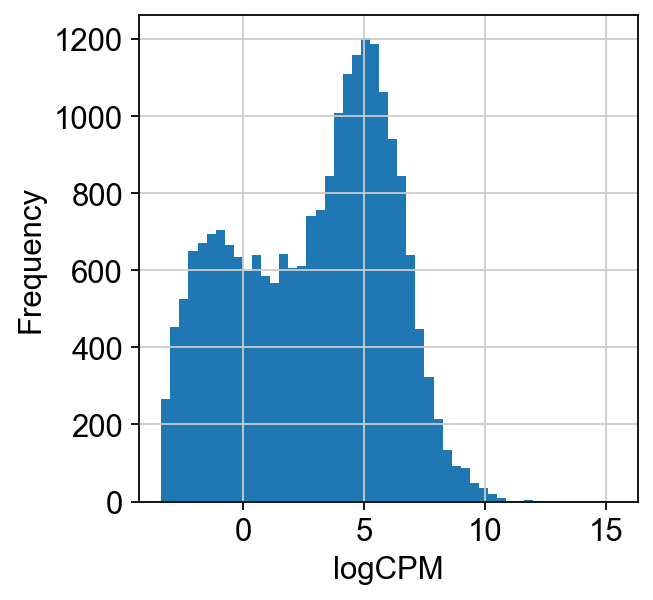

In [36]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [37]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

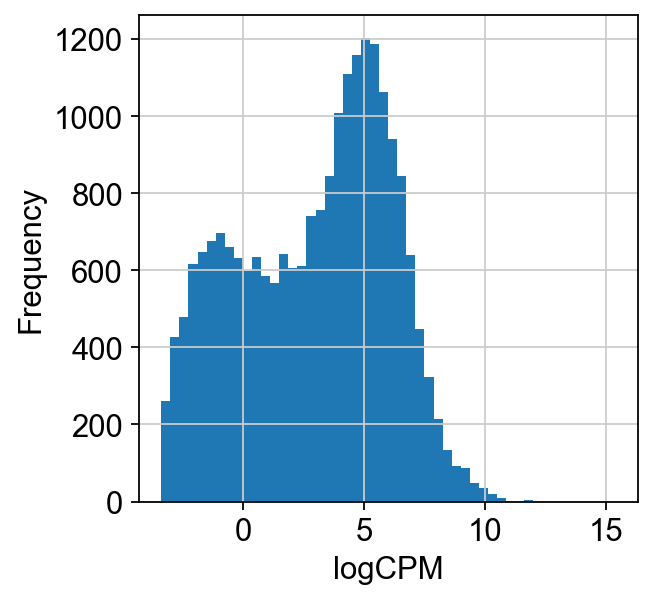

In [38]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [39]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [40]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
18638,Ly6c1,Ly6c1,ECs,ECs_vs_others,10.689237,1651.129218,7.258372,3862.425903,0.0,0.0
17766,Flt1,Flt1,ECs,ECs_vs_others,10.535135,1483.855213,9.005477,3732.093872,0.0,0.0
18715,Adgrl4,Adgrl4,ECs,ECs_vs_others,10.486824,1434.988896,7.187487,5152.738829,0.0,0.0
18182,Slco1a4,Slco1a4,ECs,ECs_vs_others,10.414659,1364.975607,7.820895,3369.302012,0.0,0.0
18692,Cldn5,Cldn5,ECs,ECs_vs_others,10.379535,1332.144955,7.203250,4130.612960,0.0,0.0
20268,Ly6a,Ly6a,ECs,ECs_vs_others,10.236198,1206.153947,6.238123,4507.069093,0.0,0.0
21747,Cdh5,Cdh5,ECs,ECs_vs_others,9.894624,951.872269,5.546905,12789.793247,0.0,0.0
19822,Mecom,Mecom,ECs,ECs_vs_others,9.788765,884.528406,6.458622,2786.664331,0.0,0.0
23390,Cd93,Cd93,ECs,ECs_vs_others,9.781243,879.929085,4.871461,11590.401496,0.0,0.0
23409,Ctla2a,Ctla2a,ECs,ECs_vs_others,9.648865,802.782030,4.864961,9317.620100,0.0,0.0


In [41]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
18692,Cldn5,Cldn5,ECs,ECs_vs_others,10.379535,1332.144955,7.203250,4130.612960,0.0,0.0
21747,Cdh5,Cdh5,ECs,ECs_vs_others,9.894624,951.872269,5.546905,12789.793247,0.0,0.0
22732,Kdr,Kdr,ECs,ECs_vs_others,8.729323,424.412449,5.141353,5318.499949,0.0,0.0


In [42]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
93543,Higd1b,Higd1b,Pericytes,Pericytes_vs_others,11.356947,2622.900004,6.353497,6534.957570,0.000000e+00,0.000000e+00
93274,Abcc9,Abcc9,Pericytes,Pericytes_vs_others,10.781105,1759.688920,6.511431,4000.426802,0.000000e+00,0.000000e+00
95978,Carmn,Carmn,Pericytes,Pericytes_vs_others,10.440587,1389.728258,5.098522,6880.402717,0.000000e+00,0.000000e+00
94807,Ndufa4l2,Ndufa4l2,Pericytes,Pericytes_vs_others,10.312387,1271.562846,5.653737,12903.598319,0.000000e+00,0.000000e+00
92903,Slc38a11,Slc38a11,Pericytes,Pericytes_vs_others,10.067377,1072.957090,6.761611,3272.223365,0.000000e+00,0.000000e+00
94137,Tbx3os1,Tbx3os1,Pericytes,Pericytes_vs_others,9.707069,835.831649,6.006554,6350.087520,0.000000e+00,0.000000e+00
92499,Vtn,Vtn,Pericytes,Pericytes_vs_others,9.681021,820.876394,7.063940,4847.774187,0.000000e+00,0.000000e+00
91474,Rgs5,Rgs5,Pericytes,Pericytes_vs_others,9.387829,669.912614,8.996759,2512.514960,0.000000e+00,0.000000e+00
92843,Slc6a20a,Slc6a20a,Pericytes,Pericytes_vs_others,9.064990,535.591742,6.807892,9142.411483,0.000000e+00,0.000000e+00
95856,Lamc3,Lamc3,Pericytes,Pericytes_vs_others,8.777354,438.779938,5.155498,7078.583182,0.000000e+00,0.000000e+00


In [45]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
92499,Vtn,Vtn,Pericytes,Pericytes_vs_others,9.681021,820.876394,7.063940,4847.774187,0.0,0.0
92180,Atp13a5,Atp13a5,Pericytes,Pericytes_vs_others,8.124369,279.047995,7.397385,5091.736607,0.0,0.0


In [46]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
97029,Acta2,Acta2,SMCs,SMCs_vs_others,12.776254,7015.127151,7.442395,6886.597833,0.000000e+00,0.000000e+00
97550,Myh11,Myh11,SMCs,SMCs_vs_others,12.037654,4204.311376,6.939783,8531.073892,0.000000e+00,0.000000e+00
97315,Tagln,Tagln,SMCs,SMCs_vs_others,11.772585,3498.656929,7.133437,15023.643305,0.000000e+00,0.000000e+00
101070,Carmn,Carmn,SMCs,SMCs_vs_others,10.654721,1612.094561,5.098522,7034.985009,0.000000e+00,0.000000e+00
97809,Slc38a11,Slc38a11,SMCs,SMCs_vs_others,10.487879,1436.038924,6.761611,3384.887193,0.000000e+00,0.000000e+00
98489,Higd1b,Higd1b,SMCs,SMCs_vs_others,10.280343,1243.630929,6.353497,9531.097428,0.000000e+00,0.000000e+00
100713,Pln,Pln,SMCs,SMCs_vs_others,10.240945,1210.128660,5.263953,8473.816536,0.000000e+00,0.000000e+00
96959,Myl9,Myl9,SMCs,SMCs_vs_others,9.869772,935.615240,7.525668,7783.776021,0.000000e+00,0.000000e+00
98650,Crispld2,Crispld2,SMCs,SMCs_vs_others,9.766227,870.817567,6.263075,3344.764627,0.000000e+00,0.000000e+00
96358,Rgs5,Rgs5,SMCs,SMCs_vs_others,9.338367,647.334406,8.996759,2472.082154,0.000000e+00,0.000000e+00


In [48]:
SMCs[SMCs.gene.isin(["Acta2", "Tagln"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
97029,Acta2,Acta2,SMCs,SMCs_vs_others,12.776254,7015.127151,7.442395,6886.597833,0.0,0.0
97315,Tagln,Tagln,SMCs,SMCs_vs_others,11.772585,3498.656929,7.133437,15023.643305,0.0,0.0


In [49]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
89375,C030029H02Rik,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.582652,766.771058,5.597741,10590.766807,0.0,0.0
91202,A330049N07Rik,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.443717,696.373369,4.883684,5315.110014,0.0,0.0
87764,9630013A20Rik,9630013A20Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.443587,696.310369,6.323802,4806.539877,0.0,0.0
86292,Fa2h,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.382205,667.306183,7.254257,5227.199121,0.0,0.0
87784,Opalin,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.352394,653.658665,6.315952,6978.896022,0.0,0.0
89846,A230001M10Rik,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.200543,588.355013,5.413873,9528.380856,0.0,0.0
89316,Enpp6,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.159714,571.937451,5.618712,11909.719956,0.0,0.0
86303,Ermn,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,9.048898,529.651014,7.244481,4889.037062,0.0,0.0
85241,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.819080,451.655713,12.994495,2374.929584,0.0,0.0
85552,Cldn11,Cldn11,Oligodendrocytes,Oligodendrocytes_vs_others,8.748460,430.079615,8.377287,4855.228143,0.0,0.0


In [50]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
85241,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.819080,451.655713,12.994495,2374.929584,0.000000e+00,0.000000e+00
85827,Mag,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.317489,319.016840,7.787116,4123.278305,0.000000e+00,0.000000e+00
85289,Mbp,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,5.559933,47.174413,9.997062,949.905845,3.191338e-179,2.802757e-178


In [51]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
103259,Igf2,Igf2,VLMCs,VLMCs_vs_others,10.926882,1946.790981,6.492864,4296.898788,0.000000e+00,0.000000e+00
106218,Tbx18,Tbx18,VLMCs,VLMCs_vs_others,10.688779,1650.604562,4.977084,10578.039265,0.000000e+00,0.000000e+00
103082,Dcn,Dcn,VLMCs,VLMCs_vs_others,10.680917,1641.634732,6.607115,1677.384597,8.096776e-297,3.898789e-295
104783,Lama1,Lama1,VLMCs,VLMCs_vs_others,9.888929,948.121936,5.671487,5102.027249,0.000000e+00,0.000000e+00
104079,Cemip,Cemip,VLMCs,VLMCs_vs_others,8.724154,422.894446,6.029747,4292.637716,0.000000e+00,0.000000e+00
105865,Lamc3,Lamc3,VLMCs,VLMCs_vs_others,8.709727,418.686702,5.155498,5498.809663,0.000000e+00,0.000000e+00
101542,Apod,Apod,VLMCs,VLMCs_vs_others,8.608291,390.259809,8.436777,3432.059913,0.000000e+00,0.000000e+00
104369,Col1a2,Col1a2,VLMCs,VLMCs_vs_others,8.478881,356.777619,5.889175,4814.318299,0.000000e+00,0.000000e+00
101321,Ptgds,Ptgds,VLMCs,VLMCs_vs_others,8.442612,347.919983,9.987632,1829.399187,5.748502e-311,2.978999e-309
102775,Slc6a20a,Slc6a20a,VLMCs,VLMCs_vs_others,8.429745,344.830923,6.807892,7386.095213,0.000000e+00,0.000000e+00


In [52]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
7935,Atp13a4,Atp13a4,Astrocytes,Astrocytes_vs_others,8.443693,348.180839,5.021175,6500.244906,0.0,0.0
6083,Gm12239,Gm12239,Astrocytes,Astrocytes_vs_others,7.542599,186.444085,5.811794,1992.120561,0.0,0.0
5941,Gm6145,Gm6145,Astrocytes,Astrocytes_vs_others,7.520401,183.597321,5.886084,6265.602770,0.0,0.0
7308,Agt,Agt,Astrocytes,Astrocytes_vs_others,7.510255,182.310602,5.291007,3720.507257,0.0,0.0
8658,Eva1a,Eva1a,Astrocytes,Astrocytes_vs_others,7.364734,164.818410,4.715368,6583.839115,0.0,0.0
7432,Etnppl,Etnppl,Astrocytes,Astrocytes_vs_others,7.355287,163.742755,5.238014,3417.628044,0.0,0.0
4331,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.266011,153.917255,6.699725,4108.871777,0.0,0.0
5039,Slc39a12,Slc39a12,Astrocytes,Astrocytes_vs_others,7.220250,149.111749,6.323121,5729.873370,0.0,0.0
8292,Itih3,Itih3,Astrocytes,Astrocytes_vs_others,7.167906,143.798643,4.874554,3204.873583,0.0,0.0
3863,Slco1c1,Slco1c1,Astrocytes,Astrocytes_vs_others,7.116806,138.794401,7.030337,3950.140187,0.0,0.0


In [53]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
4331,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.266011,153.917255,6.699725,4108.871777,0.000000e+00,0.000000e+00
8426,Gfap,Gfap,Astrocytes,Astrocytes_vs_others,6.056392,66.551182,4.814938,2239.141383,0.000000e+00,0.000000e+00
3881,Htra1,Htra1,Astrocytes,Astrocytes_vs_others,5.518537,45.840063,7.018184,2024.343787,0.000000e+00,0.000000e+00
3155,Aldoc,Aldoc,Astrocytes,Astrocytes_vs_others,4.523390,22.997262,7.784530,1195.409732,1.951017e-218,2.608991e-217


#### LRT

In [29]:
%%R -o results
head(results,2)

                logFC    logCPM        LR PValue FDR           test cell_type
ABCs.Slc47a1 13.24020  1.556248 13192.574      0   0 ABCs_vs_others      ABCs
ABCs.Lypd2   13.14272 -2.668642  7315.163      0   0 ABCs_vs_others      ABCs


In [30]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "LR", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [31]:
len(results["gene"].unique())

22438

In [32]:
results.head(2)

,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
Cd209a,Cd209a,Immune-Other,Immune-Other_vs_others,15.779917,56263.710259,-1.725706,3310.545581,0.0,0.0
H2-Aa,H2-Aa,Immune-Other,Immune-Other_vs_others,15.505304,46511.637607,-0.457343,12370.547968,0.0,0.0


In [33]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes",
        date.today().strftime("%Y%m%d") + "_DEA_LRT_def.csv",
    )
)

In [34]:
setdate = "20250201"
results = pd.read_csv(
    os.path.join(
        main_dir, "ABCAtlas_Yao2023Nature", "marker_genes", setdate + "_DEA_LRT_def.csv"
    )
)

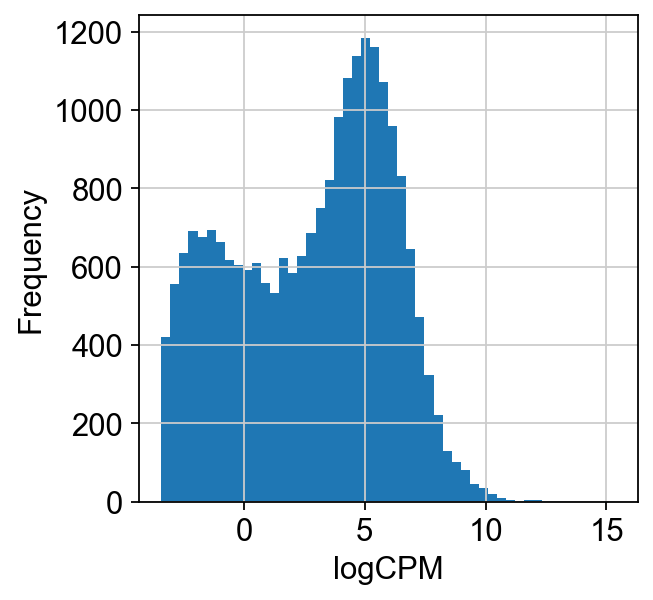

In [35]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [36]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

In [38]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [39]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
20428,Ly6c1,Ly6c1,ECs,ECs_vs_others,11.184619,2327.586898,7.358202,2010.572594,0.0,0.0
19596,Flt1,Flt1,ECs,ECs_vs_others,11.062239,2138.285844,9.127969,2341.150930,0.0,0.0
20517,Adgrl4,Adgrl4,ECs,ECs_vs_others,10.973622,2010.894725,7.264108,7767.506112,0.0,0.0
19985,Slco1a4,Slco1a4,ECs,ECs_vs_others,10.942036,1967.347919,7.933110,1558.202884,0.0,0.0
20525,Cldn5,Cldn5,ECs,ECs_vs_others,10.873881,1876.568485,7.260860,1869.803008,0.0,0.0
22051,Ly6a,Ly6a,ECs,ECs_vs_others,10.848003,1843.208289,6.300342,2308.041120,0.0,0.0
23590,Cdh5,Cdh5,ECs,ECs_vs_others,10.576584,1527.105213,5.610447,6929.806771,0.0,0.0
21643,Mecom,Mecom,ECs,ECs_vs_others,10.445469,1394.439295,6.506783,6601.295850,0.0,0.0
25428,Ctla2a,Ctla2a,ECs,ECs_vs_others,10.225057,1196.875015,4.854222,6702.930931,0.0,0.0
25439,Cd93,Cd93,ECs,ECs_vs_others,10.142359,1130.197743,4.850539,12667.994736,0.0,0.0


In [40]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
20525,Cldn5,Cldn5,ECs,ECs_vs_others,10.873881,1876.568485,7.260860,1869.803008,0.0,0.0
23590,Cdh5,Cdh5,ECs,ECs_vs_others,10.576584,1527.105213,5.610447,6929.806771,0.0,0.0
24751,Kdr,Kdr,ECs,ECs_vs_others,9.078910,540.784361,5.141477,5058.610105,0.0,0.0


In [41]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
101756,Higd1b,Higd1b,Pericytes,Pericytes_vs_others,12.215616,4756.274615,6.258805,5894.192553,0.0,0.0
101256,Abcc9,Abcc9,Pericytes,Pericytes_vs_others,11.346483,2603.944462,6.530296,9278.851585,0.0,0.0
104296,Carmn,Carmn,Pericytes,Pericytes_vs_others,11.194632,2343.797874,5.022936,10009.175099,0.0,0.0
100823,Slc38a11,Slc38a11,Pericytes,Pericytes_vs_others,10.821289,1809.391207,6.810808,2694.152013,0.0,0.0
103318,Ndufa4l2,Ndufa4l2,Pericytes,Pericytes_vs_others,10.764783,1739.892609,5.477331,21801.958551,0.0,0.0
102257,Tbx3os1,Tbx3os1,Pericytes,Pericytes_vs_others,10.305184,1265.229663,5.986093,11775.639986,0.0,0.0
100434,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.102601,1099.476269,7.104757,3624.286802,0.0,0.0
99385,Rgs5,Rgs5,Pericytes,Pericytes_vs_others,9.878352,941.196333,9.080473,1534.401686,0.0,0.0
100891,Slc6a20a,Slc6a20a,Pericytes,Pericytes_vs_others,9.505851,727.020016,6.762150,9701.100468,0.0,0.0
104267,Lamc3,Lamc3,Pericytes,Pericytes_vs_others,9.058727,533.271701,5.036799,15768.453910,0.0,0.0


In [42]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
100434,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.102601,1099.476269,7.104757,3624.286802,0.0,0.0
100098,Atp13a5,Atp13a5,Pericytes,Pericytes_vs_others,8.328381,321.434432,7.428226,7950.914302,0.0,0.0


In [43]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
105216,Acta2,Acta2,SMCs,SMCs_vs_others,13.463114,11292.787916,7.512014,5026.184533,0.000000e+00,0.000000e+00
105751,Myh11,Myh11,SMCs,SMCs_vs_others,12.425598,5501.457415,6.994872,30957.894722,0.000000e+00,0.000000e+00
105562,Tagln,Tagln,SMCs,SMCs_vs_others,12.136758,4503.271482,7.160196,7630.833423,0.000000e+00,0.000000e+00
109645,Carmn,Carmn,SMCs,SMCs_vs_others,11.409426,2720.066161,5.022936,15545.793508,0.000000e+00,0.000000e+00
106014,Slc38a11,Slc38a11,SMCs,SMCs_vs_others,11.252691,2440.043240,6.810808,2780.134081,0.000000e+00,0.000000e+00
106986,Higd1b,Higd1b,SMCs,SMCs_vs_others,11.153388,2277.740793,6.258805,5320.769381,0.000000e+00,0.000000e+00
109338,Pln,Pln,SMCs,SMCs_vs_others,10.505123,1453.305804,5.159693,7259.203690,0.000000e+00,0.000000e+00
105142,Myl9,Myl9,SMCs,SMCs_vs_others,10.066684,1072.442003,7.593731,8706.269402,0.000000e+00,0.000000e+00
107166,Crispld2,Crispld2,SMCs,SMCs_vs_others,10.051434,1061.165511,6.163315,2260.895241,0.000000e+00,0.000000e+00
104554,Rgs5,Rgs5,SMCs,SMCs_vs_others,9.832258,911.600738,9.080473,1511.832427,0.000000e+00,0.000000e+00


In [45]:
SMCs[SMCs.gene.isin(["Vtn", "Kcnj8"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
105623,Vtn,Vtn,SMCs,SMCs_vs_others,7.285312,155.990276,7.104757,2612.551036,0.0,0.0


In [46]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
96768,C030029H02Rik,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,10.004951,1027.520103,5.754758,8499.364914,0.0,0.0
98614,A330049N07Rik,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.911739,963.231891,5.036793,4202.181564,0.0,0.0
97277,A230001M10Rik,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.665157,811.899274,5.565137,5265.560538,0.0,0.0
93825,Fa2h,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.664658,811.618789,7.392370,6937.683652,0.0,0.0
95321,Opalin,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.639354,797.507529,6.409259,5002.631832,0.0,0.0
97092,Enpp6,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.507816,728.010989,5.628275,9855.603325,0.0,0.0
93859,Ermn,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,9.460716,704.626955,7.362013,3595.295130,0.0,0.0
99119,Gm19500,Gm19500,Oligodendrocytes,Oligodendrocytes_vs_others,9.297905,629.431295,4.837273,9576.908205,0.0,0.0
92891,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.097828,547.922661,13.088696,2502.317573,0.0,0.0
93176,Cldn11,Cldn11,Oligodendrocytes,Oligodendrocytes_vs_others,9.007873,514.801836,8.479425,4378.731256,0.0,0.0


In [47]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
92891,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.097828,547.922661,13.088696,2502.317573,0.0,0.0
93443,Mag,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.493552,360.424138,7.880832,3365.795084,0.0,0.0
92933,Mbp,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,6.081716,67.729685,10.024744,1617.287416,0.0,0.0


In [48]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
111785,Igf2,Igf2,VLMCs,VLMCs_vs_others,11.868465,3739.073829,6.482680,2690.097422,0.0,0.0
111687,Dcn,Dcn,VLMCs,VLMCs_vs_others,11.663652,3244.211179,6.538283,1992.683403,0.0,0.0
113628,Lama1,Lama1,VLMCs,VLMCs_vs_others,10.370820,1324.121613,5.555098,2708.277883,0.0,0.0
112881,Cemip,Cemip,VLMCs,VLMCs_vs_others,9.016976,518.060374,5.905722,3614.140521,0.0,0.0
114705,Lamc3,Lamc3,VLMCs,VLMCs_vs_others,8.995287,510.330042,5.036799,14812.312722,0.0,0.0
109976,Apod,Apod,VLMCs,VLMCs_vs_others,8.944553,492.695590,8.471667,3328.646460,0.0,0.0
110246,Pdgfra,Pdgfra,VLMCs,VLMCs_vs_others,8.880625,471.340357,7.836290,5301.433133,0.0,0.0
112556,Bgn,Bgn,VLMCs,VLMCs_vs_others,8.871432,468.346508,6.055379,4362.845948,0.0,0.0
111314,Slc6a20a,Slc6a20a,VLMCs,VLMCs_vs_others,8.856574,463.547727,6.762150,13656.294371,0.0,0.0
113010,Col1a2,Col1a2,VLMCs,VLMCs_vs_others,8.767054,435.658674,5.836818,4314.239583,0.0,0.0


In [49]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
8525,Atp13a4,Atp13a4,Astrocytes,Astrocytes_vs_others,8.655141,403.141219,5.033491,9943.573314,0.0,0.0
6806,Gm12239,Gm12239,Astrocytes,Astrocytes_vs_others,7.920383,242.255119,5.727566,2728.121225,0.0,0.0
6384,Gm6145,Gm6145,Astrocytes,Astrocytes_vs_others,7.800556,222.946880,5.925504,3555.063495,0.0,0.0
7961,Etnppl,Etnppl,Astrocytes,Astrocytes_vs_others,7.750455,215.337347,5.266224,2259.045127,0.0,0.0
9144,Eva1a,Eva1a,Astrocytes,Astrocytes_vs_others,7.709788,209.352095,4.771235,7430.436030,0.0,0.0
8359,Agt,Agt,Astrocytes,Astrocytes_vs_others,7.686246,205.963695,5.098620,1638.444726,0.0,0.0
4953,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.522661,183.885178,6.631115,1982.266518,0.0,0.0
5404,Slc39a12,Slc39a12,Astrocytes,Astrocytes_vs_others,7.486770,179.366923,6.382950,3505.305579,0.0,0.0
7983,Gm20713,Gm20713,Astrocytes,Astrocytes_vs_others,7.439461,173.580546,5.252902,3622.064220,0.0,0.0
4354,Slco1c1,Slco1c1,Astrocytes,Astrocytes_vs_others,7.412763,170.397758,7.010396,3669.482112,0.0,0.0


In [50]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
4953,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.522661,183.885178,6.631115,1982.266518,0.000000e+00,0.000000e+00
9407,Gfap,Gfap,Astrocytes,Astrocytes_vs_others,6.195784,73.302187,4.655479,1458.025014,5.171929e-319,6.310651e-318
4282,Htra1,Htra1,Astrocytes,Astrocytes_vs_others,5.814008,56.258836,7.066104,2865.434784,0.000000e+00,0.000000e+00
3601,Aldoc,Aldoc,Astrocytes,Astrocytes_vs_others,4.717087,26.301757,7.790940,1394.981735,2.587677e-305,3.002321e-304


## ~ 0 + cell_type + library_method

Including library_method (10Xv2, 10Xv3, 10X_Multi) as covariate

### run

In [21]:
%%R
method = "LRT"
#method = "QL"

In [22]:
%%R
# defaults
min.count = 10 # 10
min.total.count = 15 # 15
large.n = 10 # 10
min.prop = 0.7 # 0.7

In [23]:
%%time
%%R -i adata
model_fit <- fit_model_edgeR(se = adata, method = method, cell_type_col = "cell_type_dea", 
                             include_covariate = TRUE, covariate_col = "library_method",
                             min.count = min.count, min.total.count = min.total.count, large.n = large.n, min.prop = min.prop)

Initial dimensions: 32285x2743
After filtering: 22439x2743


CPU times: user 13h 29s, sys: 1min 48s, total: 13h 2min 17s
Wall time: 13h 2min 30s


In [24]:
%%R
head(model_fit$design,2)

  ABCs Astrocytes BAMs Bergmann ECs Ependymal Immune-Other Microglia
1    0          1    0        0   0         0            0         0
2    0          1    0        0   0         0            0         0
  Neurons-Dopa Neurons-Dopa-Gaba Neurons-Gaba Neurons-Glut Neurons-Glyc-Gaba
1            0                 0            0            0                 0
2            0                 0            0            0                 0
  Neurons-Immature Neurons-Other OECs OPCs Oligodendrocytes Pericytes SMCs
1                0             0    0    0                0         0    0
2                0             0    0    0                0         0    0
  VLMCs cov_10Xv3 cov_10xRSeq_Mult
1     0         0                0
2     0         0                0


In [25]:
%%R
cell_types <- levels(as.factor(colData(adata)$cell_type_dea))
cell_types

 [1] "ABCs"              "Astrocytes"        "BAMs"             
 [4] "Bergmann"          "ECs"               "Ependymal"        
 [7] "Immune-Other"      "Microglia"         "Neurons-Dopa"     
[10] "Neurons-Dopa-Gaba" "Neurons-Gaba"      "Neurons-Glut"     
[13] "Neurons-Glyc-Gaba" "Neurons-Immature"  "Neurons-Other"    
[16] "OECs"              "OPCs"              "Oligodendrocytes" 
[19] "Pericytes"         "SMCs"              "VLMCs"            


In [26]:
%%time
%%R
results <- run_one_vs_others_test_edgeR(model_fit$fit, model_fit$design,  
                                        cell_types, model_fit$method)

CPU times: user 1h 38min 23s, sys: 5.7 s, total: 1h 38min 29s
Wall time: 1h 38min 30s


### compare results

In [27]:
fdr_threshold = 1e-05

#### QL

In [ ]:
%%R -o results
head(results,2)

In [ ]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "F", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [ ]:
len(results["gene"].unique())

In [ ]:
results.head()

In [ ]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes",
        date.today().strftime("%Y%m%d") + "_DEA_QL_def_incllib.csv",
    )
)

In [63]:
setdate = "20250130"
results = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes",
        setdate + "_DEA_QL_def_incllib.csv",
    ),
    index_col=0,
)

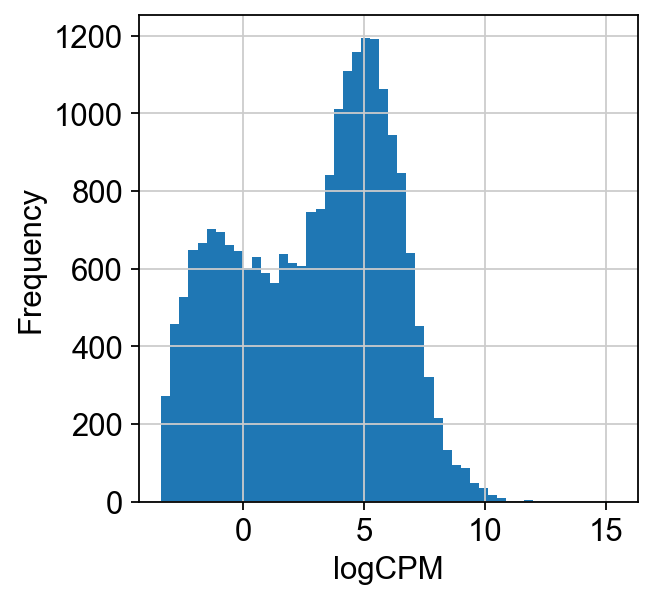

In [64]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [65]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

In [66]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [67]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
19305,Ly6c1,ECs,ECs_vs_others,10.973090,2010.153276,7.254752,4311.501847,0.0,0.0
18837,Slco1a4,ECs,ECs_vs_others,10.805996,1790.312682,7.819289,3855.969630,0.0,0.0
19385,Adgrl4,ECs,ECs_vs_others,10.704513,1668.704342,7.184386,6046.857398,0.0,0.0
18407,Flt1,ECs,ECs_vs_others,10.703439,1667.463483,9.004343,4115.385831,0.0,0.0
19372,Cldn5,ECs,ECs_vs_others,10.579305,1529.988263,7.196353,4629.558213,0.0,0.0
20974,Ly6a,ECs,ECs_vs_others,10.496767,1444.912758,6.229966,5180.918902,0.0,0.0
20516,Mecom,ECs,ECs_vs_others,10.398671,1349.931833,6.454005,3103.677294,0.0,0.0
22494,Cdh5,ECs,ECs_vs_others,10.071246,1075.838601,5.539028,14629.422343,0.0,0.0
24162,Cd93,ECs,ECs_vs_others,9.897801,953.970890,4.860147,12614.360880,0.0,0.0
24180,Ctla2a,ECs,ECs_vs_others,9.760432,867.326874,4.854782,10081.844037,0.0,0.0


In [68]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
19372,Cldn5,ECs,ECs_vs_others,10.579305,1529.988263,7.196353,4629.558213,0.0,0.0
22494,Cdh5,ECs,ECs_vs_others,10.071246,1075.838601,5.539028,14629.422343,0.0,0.0
23495,Kdr,ECs,ECs_vs_others,8.798828,445.359948,5.132206,5698.882814,0.0,0.0


In [69]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
96138,Higd1b,Pericytes,Pericytes_vs_others,11.278607,2484.271063,6.338808,8072.471774,0.000000e+00,0.000000e+00
95844,Abcc9,Pericytes,Pericytes_vs_others,10.816966,1803.977360,6.504219,4231.342846,0.000000e+00,0.000000e+00
98649,Carmn,Pericytes,Pericytes_vs_others,10.428041,1377.694699,5.082048,7375.954433,0.000000e+00,0.000000e+00
97455,Ndufa4l2,Pericytes,Pericytes_vs_others,10.225836,1197.521701,5.634130,16238.778881,0.000000e+00,0.000000e+00
95458,Slc38a11,Pericytes,Pericytes_vs_others,10.074397,1078.191264,6.756715,3417.039146,0.000000e+00,0.000000e+00
95052,Vtn,Pericytes,Pericytes_vs_others,9.718144,842.272820,7.057524,5543.500742,0.000000e+00,0.000000e+00
96746,Tbx3os1,Pericytes,Pericytes_vs_others,9.693432,827.968255,5.996196,6717.031843,0.000000e+00,0.000000e+00
93982,Rgs5,Pericytes,Pericytes_vs_others,9.379189,665.912713,8.995325,2637.042995,0.000000e+00,0.000000e+00
95398,Slc6a20a,Pericytes,Pericytes_vs_others,9.072188,538.270556,6.800709,6299.007541,0.000000e+00,0.000000e+00
98508,Lamc3,Pericytes,Pericytes_vs_others,8.799773,445.651820,5.140237,6082.305149,0.000000e+00,0.000000e+00


In [70]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
95052,Vtn,Pericytes,Pericytes_vs_others,9.718144,842.272820,7.057524,5543.500742,0.0,0.0
94709,Atp13a5,Pericytes,Pericytes_vs_others,8.124177,279.010772,7.393401,5344.463135,0.0,0.0


In [71]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
99661,Acta2,SMCs,SMCs_vs_others,12.788097,7072.951224,7.440401,7416.875958,0.000000e+00,0.000000e+00
100199,Myh11,SMCs,SMCs_vs_others,12.049319,4238.443250,6.937258,9609.160097,0.000000e+00,0.000000e+00
99955,Tagln,SMCs,SMCs_vs_others,11.778417,3512.826467,7.131376,15249.778801,0.000000e+00,0.000000e+00
103861,Carmn,SMCs,SMCs_vs_others,10.677425,1637.665374,5.082048,7505.694992,0.000000e+00,0.000000e+00
100471,Slc38a11,SMCs,SMCs_vs_others,10.487639,1435.799710,6.756715,3532.805300,0.000000e+00,0.000000e+00
101198,Higd1b,SMCs,SMCs_vs_others,10.327373,1284.839954,6.338808,11878.118334,0.000000e+00,0.000000e+00
103480,Pln,SMCs,SMCs_vs_others,10.281127,1244.307452,5.252439,8981.047045,0.000000e+00,0.000000e+00
99593,Myl9,SMCs,SMCs_vs_others,9.893283,950.987707,7.521978,8928.305589,0.000000e+00,0.000000e+00
101352,Crispld2,SMCs,SMCs_vs_others,9.822852,905.676312,6.255738,3725.041937,0.000000e+00,0.000000e+00
98978,Rgs5,SMCs,SMCs_vs_others,9.328032,642.713691,8.995325,2593.626681,0.000000e+00,0.000000e+00


In [72]:
SMCs[SMCs.gene.isin(["Vtn", "Kcnj8"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
100050,Vtn,SMCs,SMCs_vs_others,6.899331,119.372871,7.057524,3846.192535,0.0,0.0


In [73]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
91859,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.575908,763.194873,5.606031,11083.066435,0.0,0.0
88723,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.546513,747.802057,7.258672,5829.595690,0.0,0.0
93686,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.546237,747.658944,4.897326,6158.852930,0.0,0.0
92319,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.270624,617.640697,5.425590,10215.657277,0.0,0.0
90258,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.252615,609.978784,6.319334,13744.357912,0.0,0.0
90265,9630013A20Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.216762,595.006772,6.316057,5439.648641,0.0,0.0
88731,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,9.149326,567.834252,7.249622,5380.174148,0.0,0.0
91822,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.104930,550.626461,5.620481,13642.333425,0.0,0.0
87652,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.951569,495.097422,12.994626,2681.722598,0.0,0.0
88047,St18,Oligodendrocytes,Oligodendrocytes_vs_others,8.925000,486.063247,8.213018,2480.639859,0.0,0.0


In [74]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
87652,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.951569,495.097422,12.994626,2681.722598,0.000000e+00,0.000000e+00
88262,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.488190,359.087045,7.790391,4774.606643,0.000000e+00,0.000000e+00
87701,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,5.958695,62.193624,9.997761,1154.878224,2.546964e-211,2.362601e-210


In [75]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
106066,Igf2,VLMCs,VLMCs_vs_others,11.002615,2051.714890,6.485634,4973.121970,0.000000e+00,0.000000e+00
105880,Dcn,VLMCs,VLMCs_vs_others,10.729376,1697.712475,6.596927,1758.100243,7.684902e-308,3.592531e-306
107656,Lama1,VLMCs,VLMCs_vs_others,9.863402,931.493359,5.658528,5357.186869,0.000000e+00,0.000000e+00
106921,Cemip,VLMCs,VLMCs_vs_others,8.720530,421.833445,6.019534,6699.695986,0.000000e+00,0.000000e+00
108740,Lamc3,VLMCs,VLMCs_vs_others,8.705875,417.570089,5.140237,5946.826965,0.000000e+00,0.000000e+00
104059,Ptgds,VLMCs,VLMCs_vs_others,8.645282,400.395467,9.987541,2648.300018,0.000000e+00,0.000000e+00
104288,Apod,VLMCs,VLMCs_vs_others,8.633529,397.146796,8.436187,4475.065233,0.000000e+00,0.000000e+00
107226,Col1a2,VLMCs,VLMCs_vs_others,8.493207,360.338111,5.877560,5349.414153,0.000000e+00,0.000000e+00
105560,Slc6a20a,VLMCs,VLMCs_vs_others,8.477877,356.529292,6.800709,8735.600946,0.000000e+00,0.000000e+00
104597,Pdgfra,VLMCs,VLMCs_vs_others,8.422443,343.090003,7.732592,8811.634054,0.000000e+00,0.000000e+00


In [76]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
8274,Atp13a4,Astrocytes,Astrocytes_vs_others,8.570665,380.213245,5.014743,7790.810733,0.0,0.0
6367,Gm12239,Astrocytes,Astrocytes_vs_others,7.796177,222.271181,5.809119,2194.455120,0.0,0.0
6221,Gm6145,Astrocytes,Astrocytes_vs_others,7.607527,195.026536,5.881716,6598.954041,0.0,0.0
7632,Agt,Astrocytes,Astrocytes_vs_others,7.536375,185.641501,5.284124,3081.218263,0.0,0.0
7755,Etnppl,Astrocytes,Astrocytes_vs_others,7.529351,184.739809,5.233484,3953.593677,0.0,0.0
4580,Aqp4,Astrocytes,Astrocytes_vs_others,7.500008,181.020349,6.696942,4951.522553,0.0,0.0
9004,Eva1a,Astrocytes,Astrocytes_vs_others,7.495288,180.429028,4.708358,7735.581209,0.0,0.0
5298,Slc39a12,Astrocytes,Astrocytes_vs_others,7.331537,161.069187,6.320218,6437.879737,0.0,0.0
4101,Slco1c1,Astrocytes,Astrocytes_vs_others,7.329528,160.845038,7.027247,4278.136498,0.0,0.0
8637,Itih3,Astrocytes,Astrocytes_vs_others,7.305546,158.193454,4.867204,3681.497214,0.0,0.0


In [77]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
4580,Aqp4,Astrocytes,Astrocytes_vs_others,7.500008,181.020349,6.696942,4951.522553,0.000000e+00,0.000000e+00
8776,Gfap,Astrocytes,Astrocytes_vs_others,6.409401,85.000622,4.807556,2577.873044,0.000000e+00,0.000000e+00
4115,Htra1,Astrocytes,Astrocytes_vs_others,5.667677,50.832435,7.016763,2542.779644,0.000000e+00,0.000000e+00
3372,Aldoc,Astrocytes,Astrocytes_vs_others,4.838051,28.602137,7.784310,1697.221022,3.094778e-293,5.374902e-292


#### LRT

In [28]:
%%R -o results
head(results,2)

                logFC    logCPM        LR PValue FDR           test cell_type
ABCs.Slc47a1 13.23684  1.448316 13923.774      0   0 ABCs_vs_others      ABCs
ABCs.Lypd2   13.12908 -2.673453  6788.328      0   0 ABCs_vs_others      ABCs


In [29]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "LR", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [30]:
len(results["gene"].unique())

22438

In [31]:
results.head(2)

,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
H2-Aa,H2-Aa,Immune-Other,Immune-Other_vs_others,216.997631,2.102790e+65,-0.541082,587.014729,1.117507e-129,1.003029e-127
H2-Ab1,H2-Ab1,Immune-Other,Immune-Other_vs_others,186.990196,1.948309e+56,-0.479106,1217.764539,8.406065e-267,2.418252e-264


In [32]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes",
        date.today().strftime("%Y%m%d") + "_DEA_LRT_def_incllib.csv",
    )
)

In [33]:
setdate = "20250202"
results = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes",
        setdate + "_DEA_LRT_def_incllib.csv",
    )
)

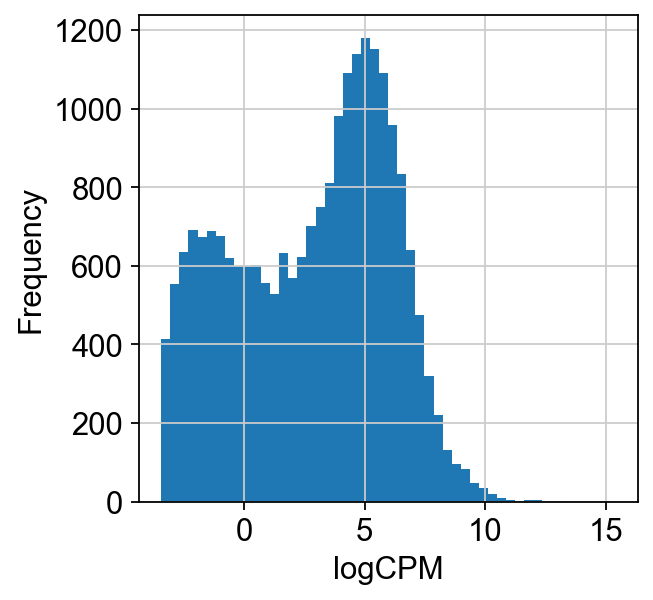

In [34]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [35]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

In [36]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [37]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
20942,Ly6c1,Ly6c1,ECs,ECs_vs_others,11.483670,2863.711448,7.319307,2032.504689,0.0,0.0
20471,Slco1a4,Slco1a4,ECs,ECs_vs_others,11.331697,2577.393047,7.903313,3529.663678,0.0,0.0
21007,Adgrl4,Adgrl4,ECs,ECs_vs_others,11.253849,2442.002996,7.251852,9250.540868,0.0,0.0
20060,Flt1,Flt1,ECs,ECs_vs_others,11.222041,2388.751990,9.105710,2386.611793,0.0,0.0
21031,Cldn5,Cldn5,ECs,ECs_vs_others,11.102612,2198.969207,7.228749,1885.052649,0.0,0.0
22679,Ly6a,Ly6a,ECs,ECs_vs_others,11.079200,2163.572809,6.246103,2230.178034,0.0,0.0
24184,Cdh5,Cdh5,ECs,ECs_vs_others,10.696734,1659.731300,5.589945,7540.852250,0.0,0.0
22170,Mecom,Mecom,ECs,ECs_vs_others,10.629952,1584.653443,6.494315,6814.803503,0.0,0.0
23304,Cyyr1,Cyyr1,ECs,ECs_vs_others,10.181572,1161.337888,5.956397,4692.229519,0.0,0.0
24660,Zfp366,Zfp366,ECs,ECs_vs_others,10.040131,1052.884119,5.400319,14345.840054,0.0,0.0


In [38]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
21031,Cldn5,Cldn5,ECs,ECs_vs_others,11.102612,2198.969207,7.228749,1885.052649,0.0,0.0
24184,Cdh5,Cdh5,ECs,ECs_vs_others,10.696734,1659.731300,5.589945,7540.852250,0.0,0.0
25300,Kdr,Kdr,ECs,ECs_vs_others,9.153933,569.650274,5.139114,5238.928612,0.0,0.0


In [39]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
103677,Higd1b,Higd1b,Pericytes,Pericytes_vs_others,12.143958,4525.801678,6.276022,6125.744023,0.000000e+00,0.000000e+00
103247,Abcc9,Abcc9,Pericytes,Pericytes_vs_others,11.423404,2746.548385,6.510440,9435.511085,0.000000e+00,0.000000e+00
102786,Slc38a11,Slc38a11,Pericytes,Pericytes_vs_others,11.048340,2117.785092,6.805448,6495.652885,0.000000e+00,0.000000e+00
105303,Ndufa4l2,Ndufa4l2,Pericytes,Pericytes_vs_others,10.609065,1561.876613,5.479613,23794.144089,0.000000e+00,0.000000e+00
104294,Tbx3os1,Tbx3os1,Pericytes,Pericytes_vs_others,10.276880,1240.649723,5.959222,11359.937646,0.000000e+00,0.000000e+00
102396,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.151450,1137.341373,7.085188,3761.612628,0.000000e+00,0.000000e+00
101310,Rgs5,Rgs5,Pericytes,Pericytes_vs_others,9.847938,921.562157,9.074663,1520.785370,0.000000e+00,0.000000e+00
102880,Slc6a20a,Slc6a20a,Pericytes,Pericytes_vs_others,9.517010,732.664853,6.747565,17016.072622,0.000000e+00,0.000000e+00
106352,Lamc3,Lamc3,Pericytes,Pericytes_vs_others,9.072658,538.446003,4.997837,16138.110755,0.000000e+00,0.000000e+00
102175,Adap2,Adap2,Pericytes,Pericytes_vs_others,9.015763,517.624858,7.285994,8157.994567,0.000000e+00,0.000000e+00


In [40]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
102396,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.151450,1137.341373,7.085188,3761.612628,0.0,0.0
102039,Atp13a5,Atp13a5,Pericytes,Pericytes_vs_others,8.324319,320.530846,7.423538,8477.026198,0.0,0.0


In [41]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
107248,Acta2,Acta2,SMCs,SMCs_vs_others,13.477576,11406.561503,7.463447,5866.414634,0.000000e+00,0.000000e+00
107784,Myh11,Myh11,SMCs,SMCs_vs_others,12.431087,5522.427325,6.984407,30986.831135,0.000000e+00,0.000000e+00
107578,Tagln,Tagln,SMCs,SMCs_vs_others,12.142414,4520.962928,7.157289,8309.931400,0.000000e+00,0.000000e+00
108047,Slc38a11,Slc38a11,SMCs,SMCs_vs_others,11.368510,2644.006770,6.805448,3323.509100,0.000000e+00,0.000000e+00
108995,Higd1b,Higd1b,SMCs,SMCs_vs_others,11.149651,2271.848550,6.276022,5562.278813,0.000000e+00,0.000000e+00
111605,Pln,Pln,SMCs,SMCs_vs_others,10.498969,1447.120276,5.075078,10496.990998,0.000000e+00,0.000000e+00
109271,Crispld2,Crispld2,SMCs,SMCs_vs_others,10.109459,1104.715203,6.131563,2299.844511,0.000000e+00,0.000000e+00
107148,Myl9,Myl9,SMCs,SMCs_vs_others,10.063834,1070.325487,7.586300,8822.662814,0.000000e+00,0.000000e+00
106546,Rgs5,Rgs5,SMCs,SMCs_vs_others,9.788574,884.411436,9.074663,3129.865890,0.000000e+00,0.000000e+00
111225,Rasl12,Rasl12,SMCs,SMCs_vs_others,9.462987,705.737297,5.247940,7424.780798,0.000000e+00,0.000000e+00


In [42]:
SMCs[SMCs.gene.isin(["Vtn", "Kcnj8"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
107656,Vtn,Vtn,SMCs,SMCs_vs_others,7.297143,157.274752,7.085188,2700.678487,0.0,0.0


In [43]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
98675,C030029H02Rik,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,10.016913,1036.075504,5.766228,8353.827039,0.0,0.0
100474,A330049N07Rik,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,10.001375,1024.976626,5.068062,4670.829137,0.0,0.0
95716,Fa2h,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.807160,895.878795,7.402338,7846.273291,0.0,0.0
99148,A230001M10Rik,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.752781,862.739420,5.595805,5782.292958,0.0,0.0
95750,Ermn,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,9.645473,800.896988,7.370791,3884.372327,0.0,0.0
97210,Opalin,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.579572,765.135709,6.424240,5053.693990,0.0,0.0
98992,Enpp6,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.505898,727.043629,5.649364,16777.192575,0.0,0.0
100989,Gm19500,Gm19500,Oligodendrocytes,Oligodendrocytes_vs_others,9.443962,696.491371,4.867881,12075.917458,0.0,0.0
94754,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.285746,624.148624,13.082013,2910.154003,0.0,0.0
95123,St18,St18,Oligodendrocytes,Oligodendrocytes_vs_others,9.181505,580.642013,8.308382,8205.354054,0.0,0.0


In [44]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
94754,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.285746,624.148624,13.082013,2910.154003,0.0,0.0
95328,Mag,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.728022,424.029706,7.888243,3798.754991,0.0,0.0
94799,Mbp,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,6.382525,83.431784,10.010735,1836.241472,0.0,0.0


In [45]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
113953,Igf2,Igf2,VLMCs,VLMCs_vs_others,11.818102,3610.798507,6.450140,5641.803430,0.0,0.0
113845,Dcn,Dcn,VLMCs,VLMCs_vs_others,11.646986,3206.950284,6.507698,2014.589676,0.0,0.0
115844,Lama1,Lama1,VLMCs,VLMCs_vs_others,10.312927,1272.039106,5.517078,2862.665298,0.0,0.0
115071,Cemip,Cemip,VLMCs,VLMCs_vs_others,9.023788,520.512200,5.875260,3713.024910,0.0,0.0
116934,Lamc3,Lamc3,VLMCs,VLMCs_vs_others,9.002368,512.841092,4.997837,15155.780038,0.0,0.0
112041,Apod,Apod,VLMCs,VLMCs_vs_others,8.925354,486.182285,8.468805,3768.906240,0.0,0.0
112318,Pdgfra,Pdgfra,VLMCs,VLMCs_vs_others,8.875957,469.817625,7.837819,5273.797040,0.0,0.0
114750,Bgn,Bgn,VLMCs,VLMCs_vs_others,8.870381,468.005311,6.025494,4325.306301,0.0,0.0
113444,Slc6a20a,Slc6a20a,VLMCs,VLMCs_vs_others,8.859974,464.641563,6.747565,13853.074081,0.0,0.0
115216,Col1a2,Col1a2,VLMCs,VLMCs_vs_others,8.774992,438.062360,5.800668,5504.428717,0.0,0.0


In [46]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
8808,Atp13a4,Atp13a4,Astrocytes,Astrocytes_vs_others,8.737793,426.911509,5.016709,10959.757148,0.0,0.0
6956,Gm12239,Gm12239,Astrocytes,Astrocytes_vs_others,8.159461,285.918621,5.758235,1826.878570,0.0,0.0
8226,Etnppl,Etnppl,Astrocytes,Astrocytes_vs_others,7.887357,236.772454,5.250214,2519.584601,0.0,0.0
6628,Gm6145,Gm6145,Astrocytes,Astrocytes_vs_others,7.887258,236.756076,5.915359,3667.169475,0.0,0.0
5110,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.846095,230.096517,6.647229,2460.382354,0.0,0.0
9450,Eva1a,Eva1a,Astrocytes,Astrocytes_vs_others,7.830638,227.644347,4.744779,8332.051958,0.0,0.0
8610,Agt,Agt,Astrocytes,Astrocytes_vs_others,7.693021,206.933106,5.097640,1641.573008,0.0,0.0
5605,Slc39a12,Slc39a12,Astrocytes,Astrocytes_vs_others,7.643220,199.911867,6.382005,4510.965967,0.0,0.0
4564,Slco1c1,Slco1c1,Astrocytes,Astrocytes_vs_others,7.614007,195.904564,6.989064,3888.599979,0.0,0.0
8281,Gm20713,Gm20713,Astrocytes,Astrocytes_vs_others,7.567177,189.647599,5.228550,3909.462070,0.0,0.0


In [47]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
5110,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.846095,230.096517,6.647229,2460.382354,0.0,0.0
9682,Gfap,Gfap,Astrocytes,Astrocytes_vs_others,6.412954,85.210210,4.638802,1644.934811,0.0,0.0
4453,Htra1,Htra1,Astrocytes,Astrocytes_vs_others,5.887710,59.207565,7.069867,3135.511025,0.0,0.0
3775,Aldoc,Aldoc,Astrocytes,Astrocytes_vs_others,5.000814,32.018054,7.763579,1879.259854,0.0,0.0
